# Your own recommender system

In this task we will take a look at music recommendations.

You will compare iALS with item-based recommendations and a simple bestsellers baseline by NDCG.

This assignment is graded by your `submission.json`.

The cell below creates a valid `submission.json` file, fill your answers in there. 

You can press "Submit Assignment" at any time to submit partial progress.

In [51]:
%%file submission.json
{
    "q1": 0.8453751171062859,
    "q2": 0.200,
    "q3": "Some artist",
    "q4": 0.300
}

Overwriting submission.json


# Imports

In [2]:
%config IPCompleter.greedy=True
%env OPENBLAS_NUM_THREADS=1
import pandas as pd
import implicit
from sklearn.model_selection import train_test_split
import scipy.sparse as sps
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from collections import defaultdict

env: OPENBLAS_NUM_THREADS=1


# Yandex.Music dataset

In [3]:
! ls -lh yandex_music

total 3.7M
-rwxrwxrwx 1 nobody nogroup 3.7M Jan 23  2021 artists.jsonl
lrwxrwxrwx 1 nobody nogroup   44 Nov 10 21:26 events.csv -> /home/jovyan/work-ro/yandex_music/events.csv
-rwxrwxrwx 1 nobody nogroup  254 Jan 23  2021 README.txt


In [4]:
! head -n 5 yandex_music/artists.jsonl

{"artistId":0,"artistName":"Mack Gordon"}
{"artistId":1,"artistName":"Kenny Dorham"}
{"artistId":2,"artistName":"Max Roach"}
{"artistId":3,"artistName":"Francis Rossi"}
{"artistId":4,"artistName":"Status Quo"}


In [5]:
! head -n 5 yandex_music/events.csv

userId,artistId,plays,skips
0,335,1,0
0,708,1,0
0,710,2,1
0,815,1,1


# Loading dataset

In [6]:
artists = pd.read_json("yandex_music/artists.jsonl", orient='records', lines=True)
print(artists.dtypes)
artists.head(5)

artistId       int64
artistName    object
dtype: object


,artistId,artistName
0,0,Mack Gordon
1,1,Kenny Dorham
2,2,Max Roach
3,3,Francis Rossi
4,4,Status Quo


In [7]:
events = pd.read_csv("yandex_music/events.csv")
print(events.dtypes)
events.head()

userId      int64
artistId    int64
plays       int64
skips       int64
dtype: object


,userId,artistId,plays,skips
0,0,335,1,0
1,0,708,1,0
2,0,710,2,1
3,0,815,1,1
4,0,880,1,1


In [8]:
# statistics
print("users:", len(set(events.userId)))
print("items:", len(set(events.artistId)))
print("interactions:", len(events))
print("density:", len(events) / (len(set(events.userId)) * len(set(events.artistId))))

users: 4999
items: 53031
interactions: 3412504
density: 0.012872420423252307


In [9]:
events, artists

(         userId  artistId  plays  skips
 0             0       335      1      0
 1             0       708      1      0
 2             0       710      2      1
 3             0       815      1      1
 4             0       880      1      1
 ...         ...       ...    ...    ...
 3412499    4997     45786      0      1
 3412500    4997     70141      0      1
 3412501    4997      2799      0      1
 3412502    4997     29637      0      1
 3412503    4997      3644      0      1
 
 [3412504 rows x 4 columns],
        artistId     artistName
 0             0    Mack Gordon
 1             1   Kenny Dorham
 2             2      Max Roach
 3             3  Francis Rossi
 4             4     Status Quo
 ...         ...            ...
 70813     70813       SMASH TV
 70814     70814           Zoom
 70815     70815    Alan Aprile
 70816     70816          Hervé
 70817     70817    Manou Gallo
 
 [70818 rows x 2 columns])

In [10]:
# most popular artists
(
    events
    .merge(artists)[['artistName', 'plays']]
    .groupby("artistName").sum()
    .sort_values('plays', ascending=False)
    .head(10)
)

,plays
artistName,
Imagine Dragons,43447
Би-2,29415
Баста,27264
Ленинград,26311
Сплин,25062
Queen,24905
Sia,22803
LOBODA,21923
Noize MC,21774


In [11]:
# train / test split
train, test = train_test_split(events, test_size=0.05, random_state=0)
print(train.shape)
print(test.shape)

(3241878, 4)
(170626, 4)


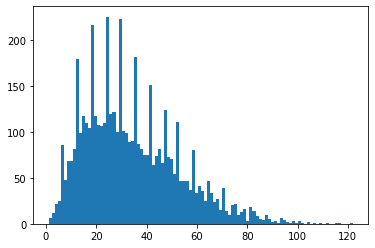

In [12]:
# number of artists per user in the test set
_ = plt.hist(test.groupby('userId').count()['plays'], bins=100)

# Train iALS

Let's say that confidence is `1 + 10 * log2(plays + 1)`

In [13]:
# prepare matrix for implicit library (https://implicit.readthedocs.io/en/latest/models.html)
# item_user (sparse csr_matrix) of item/user/confidence
# csc_matrix((data, (row_ind, col_ind)), [shape=(M, N)])
#     where ``data``, ``row_ind`` and ``col_ind`` satisfy the
#     relationship ``a[row_ind[k], col_ind[k]] = data[k]``.

item_user_train = sps.csc_matrix((1 + 10 * np.log2(train.plays + 1), (train.artistId, train.userId)))
item_user_train

<70818x4999 sparse matrix of type '<class 'numpy.float64'>'
	with 3241878 stored elements in Compressed Sparse Column format>

In [14]:
%%time
model = implicit.als.AlternatingLeastSquares(factors=32, iterations=10, random_state=0)
model.fit(item_user_train)

  0%|          | 0/10 [00:00<?, ?it/s]

CPU times: user 37.6 s, sys: 42.3 s, total: 1min 19s
Wall time: 40 s


# Similar artists (via iALS)

Let's find similar artists by cosine between their embeddings

In [15]:
target_artists = artists[artists.artistName.isin(['Coldplay', '50 Cent', 'AC/DC'])]
target_artists

,artistId,artistName
404,404,Coldplay
647,647,50 Cent
33965,33965,AC/DC


In [16]:
artist_to_name = dict(zip(artists.artistId, artists.artistName))
for _, row in target_artists.iterrows():
    print("#############", row.artistName, "#############")
    for a, s in model.similar_items(row.artistId, N=5):
        print(artist_to_name[a], "\t", s)

############# Coldplay #############
Coldplay 	 1.0
Lana Del Rey 	 0.98834753
OneRepublic 	 0.9833125
Adele 	 0.97822386
Maroon 5 	 0.97764593
############# 50 Cent #############
50 Cent 	 1.0000001
Dr. Dre 	 0.92829037
2Chainz 	 0.9079147
Lil Jon 	 0.897764
Akon 	 0.89693296
############# AC/DC #############
AC/DC 	 1.0
The Offspring 	 0.95378405
Red Hot Chili Peppers 	 0.94767326
Nirvana 	 0.9461752
Metallica 	 0.943833


# NDCG metric

In [17]:
from sklearn.metrics import ndcg_score

In [18]:
# how ndcg works in sklearn (true scores are used without exponentiation)
print(ndcg_score(y_true=[[  0,   0,   2,   1,   0]], 
                 y_score=[[0.2, 0.1, 0.5, 0.3, 0.4]]))
print((2 / np.log(1 + 1) + 1 / np.log(3 + 1)) / 
      (2 / np.log(1 + 1) + 1 / np.log(2 + 1)))

0.9502344167898358
0.9502344167898358


# NDCG for baseline

__q1: Let's compute NDCG for non-personalized baseline on the test set.__

Let's say that we rank test artists for each user by their global popularity (the sum of plays in the training dataset).

_Make sure to compute NDCG only for users with at least 2 different artists in the test set._

For each user y_true is a list where each element is a number of tracks by some author listened by the user from the test part of dataset, and 
y_score is a list of the same length where each element is a total number of some author's tracks plays from a train set.

In [1]:
# YOUR CODE HERE
import numpy as np
from sklearn.metrics import ndcg_score

# NDCG for iALS

__q2: Now let's replace global popularity with iALS prediction for each user.__

_Make sure to compute NDCG only for users with at least 2 different artists in the test set._

In [ ]:
# prediction for user 100 and item 200 (a simple dot product):
print(model.user_factors[100].dot(model.item_factors[200]))

In [ ]:
# YOUR CODE HERE

# Jaccard similarities

Let's compute Jaccard similarities for pairs of artists in the training dataset. 

Here're some details:
- Take into account only artists that the user has played at least 3 times (to cut off random plays).
- Compute jacccard similarity only for pairs that have at least 50 common users (to get confident estimates).

__q3: We will use it to recommend similar artists for users in the test set, but first let's find most similar artist to "Maroon 5" (other than "Maroon 5").__

In [ ]:
# each user has less than N=1000 artists, so N^2 is not that big
(
    train[train.plays >= 3]
    .groupby("userId").count()
    .sort_values("plays", ascending=False)
    .head(5)
)

In [ ]:
# YOUR CODE HERE

# NDCG for item-based collaborative filtering (with Jaccard similarities)

Let's compute our `prediction` for test `item` like follows:
```python
prediction = 0
for history_item, history_plays in user_train_history:
    prediction += jaccard[(history_item, item)] * history_plays
```

__q4: What NDCG do we have for item-based recommendations?__

_Make sure to compute NDCG only for users with at least 2 different artists in the test set._

In [ ]:
# YOUR CODE HERE